In [1]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# 1 a
points = [(3, 1), (4, 2), 
          (5, 3), (6, 3), (7, 3),
          (5, 4), (6, 4), (7, 4), (4, 4), (3, 4), (2, 4),
          (5, 5), (6, 5), (7, 5),
          (3, 7), (4, 6),

          (1,13), (1,14), (2,13), (2,14), (3,13), (3,14), (4,13), (4,14), (5,13), (5,14), (6,13), (6,14),
          (5,15), (6,15), (5,12), (6,12),(5,11), (6,11), (5,11),

          (10,10), (10,11), (11,9),(12,9),(13,9),(14,9),(15,10),(15,11),(11,12),(12,12),(13,12),(14,12)
]

# 1 b
# points = [(1, 13), (1, 14), (2, 13), (2, 14), (3, 13), (3, 14), (4, 13), (4, 14),
#           (3, 4), (4, 4), (5, 4),
#            (5, 6), (6, 6), (7, 6),
#             (8, 8), (9, 8), (10, 8),
#              (10, 10), (11, 10), (12, 10),
#               (13, 1), (14, 1), (15, 2), (15, 3), (13, 4), (14, 4)]

# 1 c
# points = [(1, 15), (1, 14), (1, 13), (1, 12), (1, 11), (1, 10), (1, 9), (1, 8), (1, 7),
#           (2, 15), (2, 14), (2, 13), (2, 12), (2, 11), (2, 10), (2, 9), (2, 8), (2, 7),
#           (3, 7), (4, 7), (5, 7), (6, 7),
          
#           (7, 15), (9, 15), (11, 15), (13, 15), (15, 15),
#           (7, 13), (9, 13), (11, 13), (13, 13), (15, 13),
          
#           (8, 1), (10, 1), 
#           (9, 2), (11, 2), 
#           (8, 3), (10, 3), (12, 3),
#           (9, 4), (11, 4), (13, 4),
#           (10, 5), (12, 5), (14, 5),
#           (11, 6), (13, 6), (15, 6),
#           (12, 7), (14, 7),
#           (13, 8), (15, 8),
#           ]
df = pd.DataFrame(points)


(0.0, 16.0)

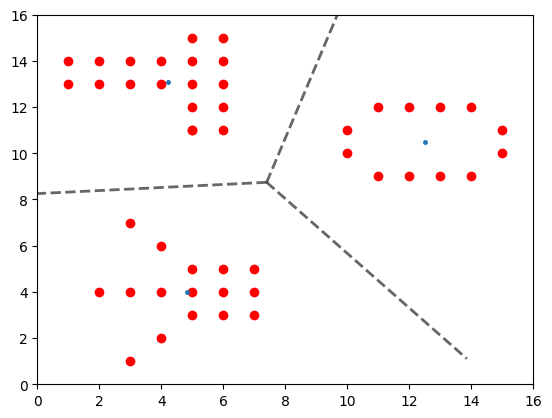

In [3]:
X = df.values
kmeans = KMeans(n_clusters=3, random_state=56).fit(X)
centers=kmeans.cluster_centers_

vor = Voronoi(centers)
ax = plt.gca()
fig = voronoi_plot_2d(vor,ax, show_points=True, show_vertices=False, line_width=2, line_alpha=0.6, point_size=5)
ax.scatter(*zip(*X), c='r')

ax.set_xlim([0, 16])
ax.set_ylim([0, 16])

In [4]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all([v >= 0 for v in vertices]):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)


(0.0, 16.0)

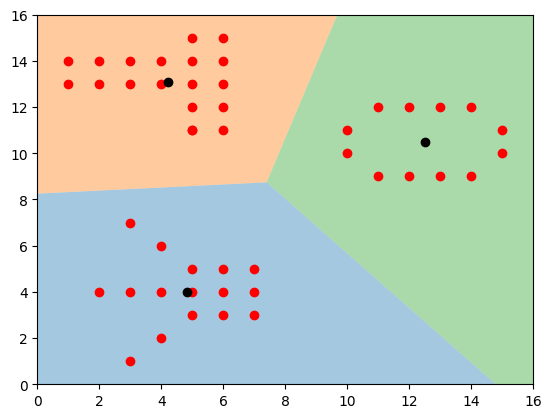

In [5]:
X = df.values 
kmeans = KMeans(n_clusters=3, max_iter=300, random_state=66).fit(X)
centers=kmeans.cluster_centers_

# compute Voronoi tesselation
vor = Voronoi(centers)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor, radius = 150)

# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(centers[:,0], centers[:,1], 'ko')
# plt.axis('equal')
plt.scatter(*zip(*X), c='r')

plt.xlim([0, 16])
plt.ylim([0, 16])